*This file, part of the* [SdePy](https://github.com/sdepy/sdepy) *package*,
*was automatically generated from* `./doc/quickguide.rst`

-----------------------------------------------
Quick Guide
===========


------------------
Install and import
------------------

Install using ``pip install sdepy``, or copy the package source code
in a directory in your Python path.

Import as



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import sdepy
import numpy as np
import matplotlib.pyplot as plt  # optional, if plots are needed
plt.rcParams['figure.figsize'] = (11., 5.5)
plt.rcParams['lines.linewidth'] = 1.


-------------------
How to state an SDE
-------------------

Here follows a bare-bone definition of a Stochastic Differential
Equation (SDE), in this case a Ornstein-Uhlenbeck process:



In [2]:
@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}


This represents the SDE ``dX = k*(theta - X)*dt + sigma*dW(t)``,
where ``theta``, ``k`` and ``sigma`` are parameters and ``dW(t)`` are Wiener
process increments. A further ``'dn'`` or ``'dj'`` entry in the returned
dictionary would allow for Poisson or compound Poisson jumps.

A number of preset processes are provided, including lognormal processes,
Hull-White n-factor processes, Heston processes, and jump-diffusion processes.


-----------------------
How to integrate an SDE
-----------------------

Now ``my_process`` is a class, a subclass of the cooperating
``sdepy.SDE`` and ``sdepy.integrator`` classes:



In [3]:
issubclass(my_process, sdepy.integrator), issubclass(my_process, sdepy.SDE)


(True, True)

It is to be instantiated with a number
of parameters, including the SDE parameters ``theta``, ``k`` and ``sigma``;
its instances are callable, given a timeline they will integrate and
return the process along it. Decorating ``my_process`` with ``sdepy.kunfc``
allows for more concise handling of parameters:



In [4]:
myp = sdepy.kfunc(my_process)


It is best explained by examples, involving ``my_process``, ``myp`` and



In [5]:
coarse_timeline = (0., 0.25, 0.5, 0.75, 1.0)
timeline = np.linspace(0., 1., 500)


1. **Scalar process** in 100000 paths, with default parameters, computed
   at 5 time points (``coarse_timeline``), using 100 steps in between:



In [6]:
x = my_process(x0=1, paths=100*1000,
               steps=100)(coarse_timeline)
x.shape


(5, 100000)

2. The same scalar process computed on a **fine-grained timeline**
   (``timeline``) and 1000 paths, using **one integration step for each point
   in the timeline** (no ``steps`` parameter):



In [7]:
x = my_process(x0=1, paths=1000,
               steps=100)(timeline)
x.shape


(500, 1000)

   A plot of a few paths may be used to **inspect the integration result**:



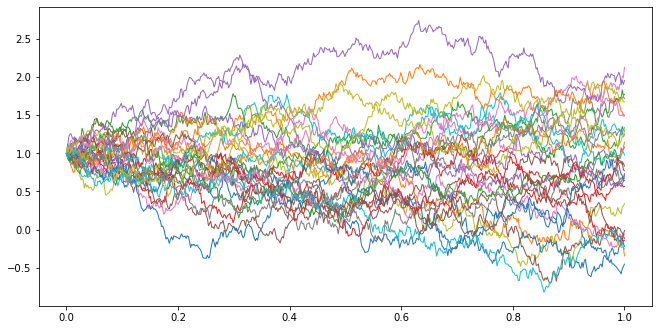

In [8]:
gr = plt.plot(timeline, x[:, :30])
plt.show()


2. **Vector process** with three components and
   **correlated Wiener increments**
   (same other parameters as above):



In [9]:
corr = ((1, .2, -.3), (.2, 1, .1), (-.3, .1, 1))
x = my_process(x0=1, vshape=3, corr=corr,
               paths=1000)(timeline)
x.shape


(500, 3, 1000)

3. Vector process as above, with 10000 paths and
   **time-dependent parameters and correlations**:



In [10]:
sigma = lambda t: 0.1 + t
theta = lambda t: 2-t
k = lambda t: 2/(t+1)
c02 = lambda t: -0.1*np.cos(3*t)
c12 = lambda t: 0.1*np.sign(0.5-t)
corr = lambda t: ((     1,    -.2, c02(t)),
                  (   -.2,      1, c12(t)),
                  (c02(t), c12(t),      1))
x = my_process(x0=1, vshape=3, corr=corr,
               theta=theta, k=k, sigma=sigma, paths=10*1000)(timeline)
x.shape


(500, 3, 10000)

   This plot illustrates the correlations among the components of
   ``x`` increments, as a function of time and as compared to
   ``corr(t)``:



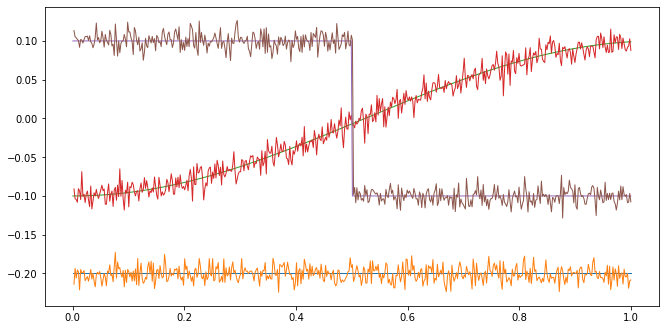

In [11]:
dx = np.diff(x, axis=0)
for i in range(3):
    for j in range(i + 1, 3):
        gr = plt.plot(
            timeline, corr(timeline)[i][j] + 0*timeline,
            timeline[1:], [np.cov(z)[i, j]/(z[i].std()*z[j].std())
                           for z in dx]
            )
plt.show()


4. A 1000 paths scalar process with **path-dependent initial conditions
   and parameters**, integrated **backwards** (``i0=-1``):



In [12]:
x0, sigma = np.zeros(1000), np.zeros(1000)
x0[::2], x0[1::2] = 0., 2.
sigma[::2], sigma[1::2] = 0.5, 0.1
x = my_process(x0=x0, sigma=sigma, paths=1000,
               theta=1, k=-2,
               i0=-1)(timeline)
x.shape


(500, 1000)

   When integrating backwards, the inital conditions are applied
   at the final point in the given timeline:



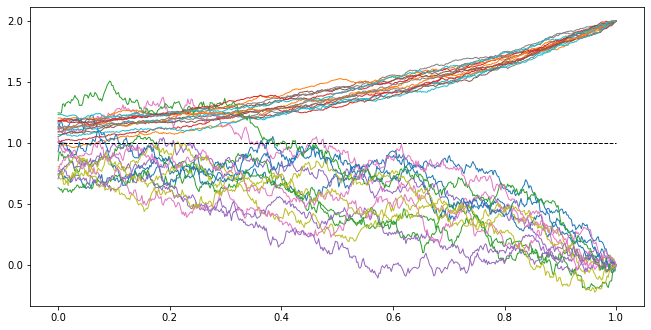

In [13]:
assert (x[-1, :] == x0).all()
gr = plt.plot(timeline, x[:, :30])
gr = plt.plot(timeline, np.full_like(timeline, 1), 'k--')
plt.show()


   Note the negative value of ``k``, with mean reversion
   towards ``theta=1`` occurring backwards in time.

5. A scalar process computed on a **10 x 15 grid of parameters** ``sigma`` and
   ``k`` (note that the shape of the initial conditions and of each
   parameter should be broadcastable to the values of the process across
   paths, i.e. to shape ``vshape + (paths,)``):



In [14]:
sigma = np.linspace(0., 1., 10).reshape(10, 1, 1)
k = np.linspace(1., 2., 15).reshape(1, 15, 1)
x = my_process(x0=1, theta=2, k=k, sigma=sigma, vshape=(10, 15),
               paths=10*1000)(coarse_timeline)
x.shape


(5, 10, 15, 10000)

   A plot of the final average process values against ``k``
   illustrates a faster reversion to ``theta=2`` as
   ``k`` increases, as well as the independence of the
   process mean from ``sigma``:



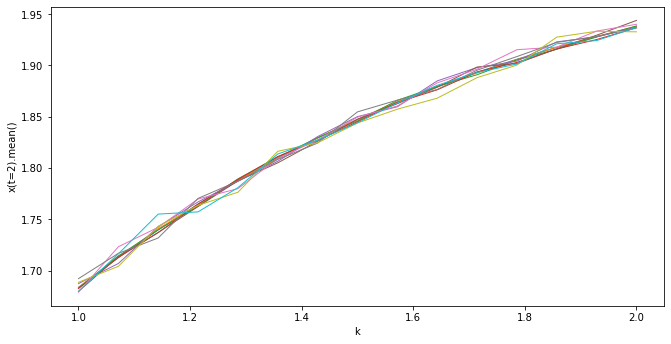

In [15]:
for i in range(10):
    gr = plt.plot(k[0, :, 0], x[-1, i, :, :].mean(axis=-1))
lb = plt.xlabel('k'), plt.ylabel('x(t=2).mean()')
plt.show()


   In the example above, set ``steps>=100`` to go from inaccurate and fast,
   to meaningful and slow.

6. **Interactive modification** of process and integration parameters
   using the ``sdepy.kfunc`` decorator ``myp = sdepy.kfunc(my_process)``.

   The ``sdepy.kfunc`` decorated version of ``my_process`` is a subclass
   of ``sdepy.integrator`` and ``sdepy.SDE``, as ``my_process`` is,
   and fully replicates its functionality and interface:



In [16]:
issubclass(myp, sdepy.integrator), issubclass(myp, sdepy.SDE)


(True, True)

   In addition, and in contrast to ``my_process``,
   ``myp`` instances accept either an integration timeline,
   or a modified value of some integration or SDE parameters,
   or both, as illustrated below:



In [17]:
p = myp(x0=1, sigma=1, paths=1000)

x = p(timeline)
x1, x2 = p(timeline, sigma=0.5), p(timeline, sigma=1.5)
q = p(paths=100, vshape=(3,), k=2)
y = q(timeline, sigma=0.5)


   ``x`` is the result of integrating ``p`` along ``timeline``
   (no difference here from a ``my_process`` instance);
   ``x1, x2`` are obtained by integration along ``timeline``
   by setting ``sigma`` to the given values,
   and keeping other parameters as stated when ``p`` was instantiated;
   ``q`` is another ``myp`` instance with updated default values
   for ``paths``, ``vshape`` and ``k``, and all else set as in ``p``;
   and finally, ``y`` was obtained by integrating ``q`` along ``timeline``,
   with its own parameters, save for ``sigma`` that was modified to ``0.5``.

   Moreover, for ``sdepy.kfunc`` classes, instantiation and computation
   may happen contextually:



In [18]:
x = myp(timeline, x0=1, sigma=1, paths=1000)


   is equivalent to:



In [19]:
x = my_process(x0=1, sigma=1, paths=1000)(timeline)


   ``sdepy.kfunc``-decorated classes allow to **state some central values
   of parameters for a given problem**, and to explore the effects
   of variatons in some of them via a concise interface,
   that **keeps the modified parameters in focus**
   and all the rest in the background.

   To **inspect the parameters stored** in a ``sdepy.kfunc`` instance,
   use the read-only ``params`` attribute:



In [20]:
q.params


{'paths': 100,
 'vshape': (3,),
 'dtype': None,
 'rng': None,
 'steps': None,
 'i0': 0,
 'info': None,
 'getinfo': True,
 'method': 'euler',
 'x0': array(1),
 'sigma': array(1),
 'k': array(2),
 'dw': None,
 'corr': None,
 'rho': None,
 'theta': array(1.)}

   To test if an object is a kfunc, use ``sdepy.iskfunc()``:



In [21]:
sdepy.iskfunc(myp), sdepy.iskfunc(p), sdepy.iskfunc(my_process)


(True, True, False)

   The examples that follow illustrate, among other things, the
   use of ``myp`` as a ``sdepy.kfunc`` class.

7. Processes generated using **integration results as stochasticity sources**
   (mind using consistent ``vshape`` and ``paths``, and synchronizing timelines):



In [22]:
my_dw = sdepy.integrate(lambda t, x: {'dw': 1})(vshape=1, paths=1000)(timeline)
p = myp(dw=my_dw, vshape=3, paths=1000,
        x0=1, sigma=((1,), (2,), (3,)))
x = p(timeline)
x.shape


(500, 3, 1000)

   Now, ``x1, x2, x3 = = x[:, 0], x[:, 1], x[:, 2]`` have different ``sigma``,
   but share the same ``dw`` increments, as can be seen plotting a path:



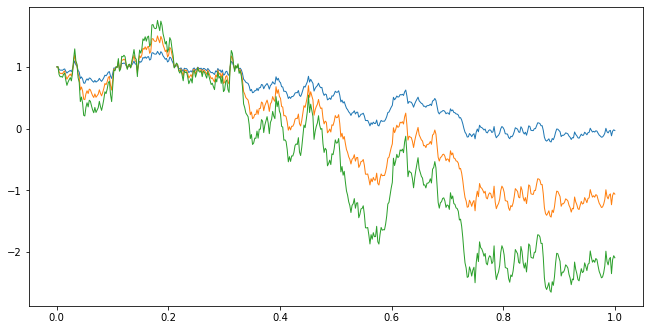

In [23]:
k = 0  # path to be plotted
gr = plt.plot(timeline, x[:, :, k])
plt.show()


   If more integrations steps are needed between points in the output timeline,
   use ``steps`` to keep the integration timeline consistent with the one
   of ``my_dw``:



In [24]:
x = p(coarse_timeline, steps=timeline)
x.shape


(5, 3, 1000)

8. Using **stochasticity sources with memory**
   (mind using consistent ``vshape`` and ``paths``):



In [25]:
my_dw = sdepy.true_wiener_source(paths=1000)
p = myp(x0=1, theta=1, k=1, sigma=1, dw=my_dw, paths=1000)


   ``my_dw``, as a ``sdepy.true_wiener_source`` instance
   has memory of, and generates new Wiener process increments
   consistent with, its formerly realized values.
   As a consequence, processes defined invoking ``p``
   share the same underlying Wiener process increments:



In [26]:
t1 = np.linspace(0., 1.,  30)
t2 = np.linspace(0., 1., 100)
t3 = t = np.linspace(0., 1., 300)
x1, x2, x3 = p(t1), p(t2), p(t3)
y1, y2, y3 = p(t, theta=1.5), p(t, theta=1.75), p(t, theta=2)


   ``x1, x2, x3`` illustrate SDE integration convergence as time steps
   become smaller, and ``y1, y2, y3`` illustrate
   how ``theta`` affects paths, all else being equal:



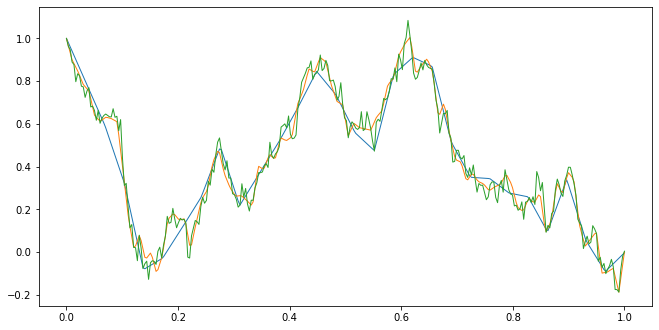

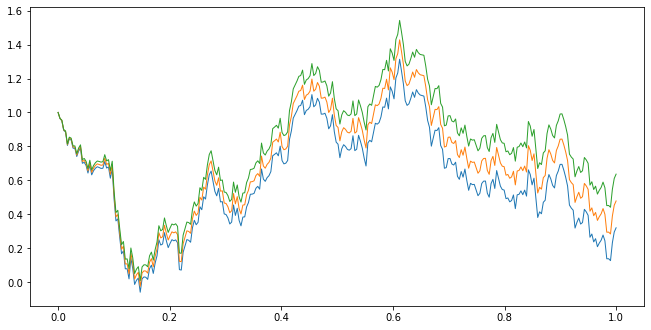

In [27]:
i = 0 # path to be plotted
gr = plt.plot(t, x1(t)[:, i], t, x2(t)[:, i], t, x3(t)[:, i])
plt.show() 
gr = plt.plot(t, y1[:, i], t, y2[:, i], t, y3[:, i])
plt.show()


------------------------------------
How to handle the integration output
------------------------------------

SDE integrators return instances of ``sdepy.process``,
a subclass of ``np.ndarray``
with a timeline stored in the ``t`` attribute
(note the shape of ``x``,
repeatedly used in the examples below):



In [28]:
coarse_timeline = (0., 0.25, 0.5, 0.75, 1.0)
timeline = np.linspace(0., 1., 101)
x = my_process(x0=1, vshape=3, paths=1000)(timeline)
x.shape


(101, 3, 1000)

``x`` is a ``sdepy.process`` instance:



In [29]:
type(x)


sdepy.infrastructure.process

and is based on the given timeline:



In [30]:
np.isclose(timeline, x.t).all()


True

Whenever possible, a process will store references, not copies, of timeline
and values. In fact:



In [31]:
timeline is x.t


True

The first axis is reserved for the timeline, the last for paths, and axes
in the middle match the shape of process values:



In [32]:
x.shape == x.t.shape + x.vshape + (x.paths,)


True

Calling processes interpolates in time:



In [33]:
y = x(coarse_timeline)
y.shape


(5, 3, 1000)

The result is always an array, not a process:



In [34]:
type(y)


numpy.ndarray

Indexing works as usual, and returns NumPy arrays:



In [35]:
type(x[0])


numpy.ndarray

All array methods are unchanged  (no overriding),
and return NumPy arrays as well:



In [36]:
type(x.mean(axis=0))


numpy.ndarray

You can slice processes along time, values and paths with special indexing.

- Time indexing:



In [37]:
y = x['t', ::2]
y.shape


(51, 3, 1000)

- Values indexing:



In [38]:
y = x['v', 0]
y.shape


(101, 1000)

- Paths indexing:



In [39]:
y = x['p', :10]
y.shape


(101, 3, 10)

The output of a special indexing operation is a process:



In [40]:
isinstance(y, sdepy.process)


True

Smart indexing is allowed. To select paths that cross ``x=0``
at some point and for some component, use:



In [41]:
i_negative = x.min(axis=(0, 1)) < 0
y = x['p', i_negative]
y.shape == (101, 3, i_negative.sum())


True

You can do algebra with processes that either share the same timeline, or are constant
(a process with a one-point timeline is assumed to be constant), and either have the
same number of paths, or are deterministic (with one path):



In [42]:
x_const = x['t', 0]  # a constant process
x_one_path = x['p', 0]  # a process with one path

y = np.exp(x) - x_const
z = np.maximum(x, x_one_path)

isinstance(y, sdepy.process), isinstance(z, sdepy.process)


(True, True)

When integrating SDEs, the SDE parameters and/or stochasticity sources
accept processes as valid values (mind using deterministic processes, or
synchronizing the number of paths, and make sure that the shape of values
do broadcast together). To use a realization of ``my_process``
as the volatility of a 3-component lognormal process, do as follows:



In [43]:
stochastic_vol = my_process(x0=1, paths=10*1000)(timeline)
stochastic_vol_x = sdepy.lognorm_process(x0=1, vshape=3, paths=10*1000,
    mu=0, sigma=stochastic_vol)(timeline)


Processes have specialized methods, and may be analyzed, and their statistics
cumulated across multiple runs, using the ``sdepy.montecarlo`` class. Some examples follow:

1. Cumulative probability distribution function at t=0.5
   of the process values of ``x`` across paths:



In [44]:
cdf = x.cdf(0.5, x=np.linspace(-2, 2, 100))  # an array


2. Characteristic function at t=0.5 of the same distribution:



In [45]:
chf = x.chf(0.5, u=np.linspace(-2, 2, 100))  # an array


3. Standard deviation across paths:



In [46]:
std = x.pstd()  # a one-path process
std.shape


(101, 3, 1)

4. Maximum value reached along the timeline:



In [47]:
xmax = x.tmax()  # a constant process
xmax.shape


(1, 3, 1000)

5. A linearly interpolated, or Gaussian kernel estimate (default)
   of the probability distribution function (pdf) and its cumulated
   values (cdf) across paths, at a given time point,
   may be obtained using the ``montecarlo`` class:



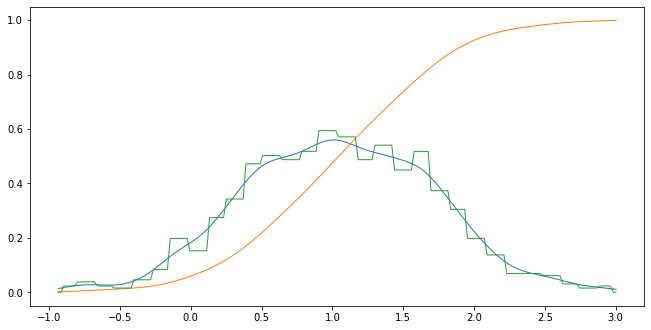

In [48]:
y = x(1)[0]  # 0-th component of x at time t=1
a = sdepy.montecarlo(y, bins=30)
ygrid = np.linspace(y.min(), y.max(), 200)
gr = plt.plot(ygrid, a.pdf(ygrid), ygrid, a.cdf(ygrid))
gr = plt.plot(ygrid, a.pdf(ygrid, method='interp', kind='nearest'))
plt.show()


6. A ``sdepy.montecarlo`` instance can be used to cumulate the results
   of multiple simulations, across multiple components of process values:



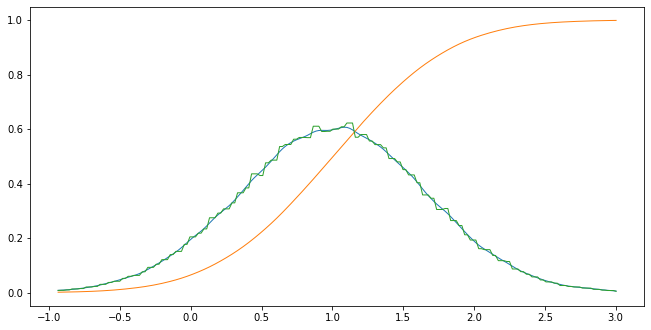

In [49]:
p = my_process(x0=1, vshape=3, paths=10*1000)
a = sdepy.montecarlo(bins=100)  # empty montecarlo instance
for _ in range(10):
    x = p(timeline)  # run simulation
    a.update(x(1))  # cumulate x values at t=1
a.paths
gr = plt.plot(ygrid, a[0].pdf(ygrid), ygrid, a[0].cdf(ygrid))
gr = plt.plot(ygrid, a[0].pdf(ygrid, method='interp', kind='nearest'))
plt.show()


--------------------------------
Example - Stochastic Runge-Kutta
--------------------------------

Minimal implementation of a basic stochastic Runge-Kutta integration
scheme, as a subclass of ``sdepy.integrator``
(the ``A`` and ``dZ`` methods below are the standardized way
in which equations are exposed to integrators):



In [50]:
from numpy import sqrt
class my_integrator(sdepy.integrator):
    def next(self):
        t, new_t = self.itervars['sw']
        x, new_x = self.itervars['xw']
        dt = new_t - t
        A, dZ = self.A(t, x), self.dZ(t, dt)
        a, b, dw = A['dt'], A['dw'], dZ['dw']
        b1 = self.A(t, x + a*dt + b*sqrt(dt))['dw']
        new_x[...] = x + a*dt + b*dw + (b1 - b)/2 * (dw**2 - dt)/sqrt(dt)


SDE of a lognormal process, as a subclass of ``sdepy.SDE``,
and classes that integrate it with the default integration method
(``euler``) and via ``my_integrator`` (``rk``):



In [51]:
class my_SDE(sdepy.SDE):
    def sde(self, t, x):
        return {'dt': 0, 'dw': x}

class euler(my_SDE, sdepy.integrator):
    pass

class rk(my_SDE, my_integrator):
    pass


Comparison of integration errors, as the integration from ``t=0`` to
``t=1`` is carried out with an increasing number of steps, against
the integration result of ``sdepy.lognorm_process``, which returns
an exact result irrespective of the number and size
of the integration steps (this happens since, by implementation,
it integrates the linear SDE for ``log(x)``):



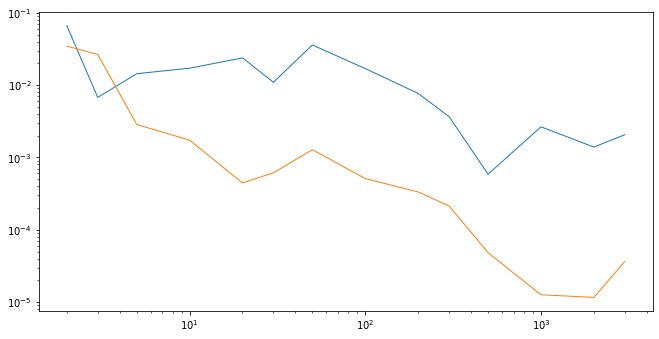

euler error: 2.06e-03
   rk error: 3.65e-05


In [52]:
args = dict(dw=sdepy.true_wiener_source(paths=100),
            paths=100, x0=10)
timeline = (0, 1)
steps = np.array((2, 3, 5, 10, 20, 30, 50, 100,
                  200, 300, 500, 1000, 2000, 3000))

# exact integration results at t=1
exact = sdepy.lognorm_process(mu=0, sigma=1, **args)(timeline)[-1].mean()

# errors of approximate integration results at t=1
errors = np.abs(np.array([
    [euler(**args, steps=s)(timeline)[-1].mean()/exact - 1,
     rk(**args, steps=s)(timeline)[-1].mean()/exact - 1]
    for s in steps]))

# plots
ax = plt.axes(label=0); ax.set_xscale('log'); ax.set_yscale('log')
gr = ax.plot(steps, errors)
plt.show()  
print(f'euler error: {errors[-1,0]:.2e}\n'
      f'   rk error: {errors[-1,1]:.2e}')


--------------------------------
Example - Fokker-Planck Equation
--------------------------------

Monte Carlo integration of partial differential equations, illustrated
in the simplest example of the heat equation ``diff(u, t) - k*diff(u, x, 2) == 0``,
for the function ``u(x, t)``, i.e. the Fokker-Planck equation for the SDE
``dX(t) = sqrt(2*k)*dW(t)``. Initial conditions at ``t=t0``, two examples:

1.  ``u(x, t0) = 1`` for ``lb < x < hb`` and ``0`` otherwise,
2.  ``u(x, t0) = sin(x)``.

Setup:



In [53]:
from numpy import exp, sin
from scipy.special import erf
from scipy.integrate import quad

k = .5
x0, x1 = 0, 10;
t0, t1 = 0, 1
lb, hb = 4, 6


Exact green function and solutions for initial conditions
1. and 2., to be checked against results:



In [54]:
def green_exact(y, s, x, t):
    return exp(-(x - y)**2/(4*k*(t - s)))/sqrt(4*np.pi*k*(t - s))

def u1_exact(x, t):
    return (erf((x - lb)/2/sqrt(k*(t - t0))) - erf((x - hb)/2/sqrt(k*(t - t0))))/2

def u2_exact(x, t):
    return exp(-k*(t - t0))*sin(x)


Realization of the needed stochastic process, by backward integration from
a grid of final values of ``x`` at ``t=t1``, using the preset
``wiener_process`` class (the ``steps`` keyword is added as a reminder
of the setup needed for less-than-trivial equations, it does not actually
make a difference here):



In [55]:
xgrid = np.linspace(x0, x1, 51)
tgrid = np.linspace(t0, t1, 5)
xp = sdepy.wiener_process(
    paths=10000, steps=100,
    sigma=sqrt(2*k),
    vshape=xgrid.shape, x0=xgrid[..., np.newaxis],
    i0=-1,
    )(timeline=tgrid)


Computation of the green function and of the solutions ``u(x, t1)``
via Monte Carlo integration
(note the liberal use of ``scipy.integrate.quad`` below, enabled by
the smoothness of the Gaussian kernel estimate ``a[i, j].pdf``):



In [56]:
a = sdepy.montecarlo(xp, bins=100)

def green(y, i, j):
    """green function from (y=y, s=tgrid[i]) to (x=xgrid[j], t=t1)"""
    return a[i, j].pdf(y)

u1, u2 = np.empty(51), np.empty(51)
for j in range(51):
    u1[j] = quad(lambda y: green(y, 0, j), lb, hb)[0]
    u2[j] = quad(lambda y: sin(y)*green(y, 0, j), -np.inf, np.inf)[0]


Comparison against exact values:



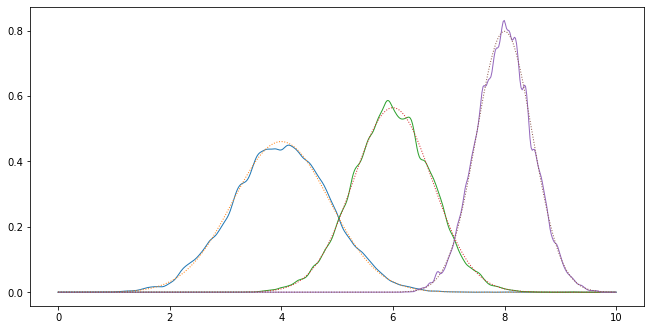

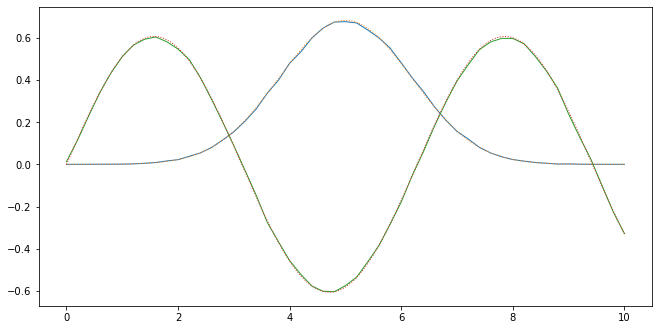

u1 error: 2.03e-03
u2 error: 4.55e-03


In [57]:
y = np.linspace(x0, x1, 500)
for i, j in ((1, 20), (2, 30), (3, 40)):
    gr = plt.plot(y, green(y, i, j),
                  y, green_exact(y, tgrid[i], xgrid[j], t1), ':')
plt.show()  

gr = plt.plot(xgrid, u1, y, u1_exact(y, t1), ':')
gr = plt.plot(xgrid, u2, y, u2_exact(y, t1), ':')
plt.show()  

print(f'u1 error: {np.abs(u1 - u1_exact(xgrid, t1)).mean():.2e}\n'
      f'u2 error: {np.abs(u2 - u2_exact(xgrid, t1)).mean():.2e}'
)


--------------------------------
Example - Basket Lookback Option
--------------------------------

Take a basket of 4 financial securities, with risk-neutral probabilities following
lognormal processes in the Black-Scholes framework. Correlations, dividend yields
and term structure of volatility (will be linearly interpolated) are given below:



In [58]:
corr = [
    [1,    0.50, 0.37, 0.35],
    [0.50,    1, 0.47, 0.46],
    [0.37, 0.47,    1, 0.19],
    [0.35, 0.46,  0.19,   1]]

dividend_yield = sdepy.process(c=(0.20, 4.40, 0., 4.80))/100
riskfree = 0  # to keep it simple

vol_timepoints = (0.1, 0.2, 0.5, 1, 2, 3)
vol = np.array([
    [0.40, 0.38, 0.30, 0.28, 0.27, 0.27],
    [0.31, 0.29, 0.22, 0.16, 0.18, 0.21],
    [0.24, 0.22, 0.19, 0.19, 0.21, 0.22],
    [0.35, 0.31, 0.21, 0.18, 0.19, 0.19]])
sigma = sdepy.process(t=vol_timepoints, v=vol.T)
sigma.shape


(6, 4, 1)

The prices of the securities at the end of each quarter for the next 2 years,
simulated across 50000 independent paths and their antithetics
(``sdepy.odd_wiener_source`` is used), are:



In [59]:
maturity = 2
timeline = np.linspace(0, maturity, 4*maturity + 1)
p = sdepy.lognorm_process(
    x0=100, corr=corr, dw=sdepy.odd_wiener_source,
    mu=(riskfree - dividend_yield),
    sigma=sigma,
    vshape=4, paths=100*1000, steps=maturity*250)
x = p(timeline)
x.shape


(9, 4, 100000)

A call option knocks in if any of the securities reaches a price below 80
at any quarter (starting from 100), and pays the lookback maximum attained
by the basket (equally weighted), minus 105, if positive.
Its price is:



In [60]:
x_worst = x.min(axis=1)
x_basket = x.mean(axis=1)
down_and_in_paths = (x_worst.min(axis=0) < 80)
lookback_x_basket = x_basket.max(axis=0)
payoff = np.maximum(0, lookback_x_basket - 105)
payoff[np.logical_not(down_and_in_paths)] = 0
a = sdepy.montecarlo(payoff, use='even')
print(a)


5.070396297161243 +/- 0.027036197923264633
